# Predict Future Sales

* Time series data consisting of daily sales from Russian software company.
* Historical data available from Jan 2013 to Oct 2015.
* Predict total sales for every product and store for Nov 2015, at the monthly level.
* List of shops and products changes slightly every month.

## 1. Load Data

In [1]:
## Load library 
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from datetime import datetime, timedelta
from category_encoders import TargetEncoder 
import xgboost as xgb

# Load data
sales_train = pd.read_csv('data/sales_train.csv')
test = pd.read_csv('data/test.csv')
items = pd.read_csv('data/items.csv')
item_cat = pd.read_csv('data/item_categories.csv')
shops = pd.read_csv('data/shops.csv')

### 1.1 Sales

* date: date in format dd/mm/yyyy.
* date_block_num: consecutive month number, starting with Jan 2013=0, Feb 2013=1 ... Oct 2015=33.
* shop_id: unique identifier for a shop.
* item_id: unique identifier for a product.
* item_price: current price of product.
* item_cnt_day: daily sales of a product. 

In [2]:
sales_train['date'] = pd.to_datetime(sales_train['date'], format='%d.%m.%Y')
sales_train.head(20)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0
5,2013-01-10,0,25,2564,349.00,1.0
6,2013-01-02,0,25,2565,549.00,1.0
7,2013-01-04,0,25,2572,239.00,1.0
8,2013-01-11,0,25,2572,299.00,1.0
9,2013-01-03,0,25,2573,299.00,3.0


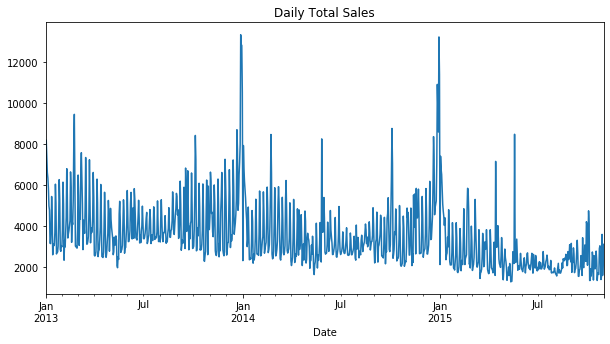

In [3]:
sales_train.groupby('date')['item_cnt_day'].sum()\
.plot(y='item_cnt_day', kind='line', colormap='tab20', figsize=(10,5))
plt.title('Daily Total Sales')
plt.xlabel('Date')
plt.show()

Above figure is a plot of daily total sales by the company. There are seasonal patterns in the data. Taking a closer look at these patterns below through the following
* weekly rolling mean
* 30-day (1 month) rolling mean
* 90-day (3 month) rolling mean

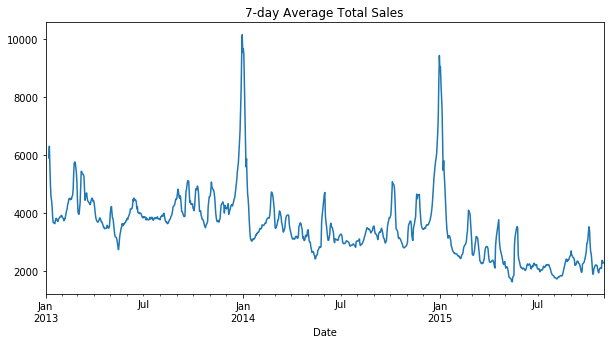

In [4]:
sales_train.groupby('date')['item_cnt_day'].sum()\
.rolling(window=7).mean()\
.plot(y='item_cnt_day', kind='line', colormap='tab20', figsize=(10,5))
plt.title('7-day Average Total Sales')
plt.xlabel('Date')
plt.show()

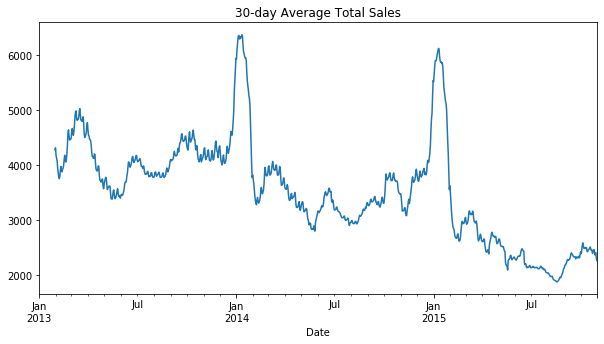

In [5]:
sales_train.groupby('date')['item_cnt_day'].sum()\
.rolling(window=30).mean()\
.plot(y='item_cnt_day', kind='line', colormap='tab20', figsize=(10,5))
plt.title('30-day Average Total Sales')
plt.xlabel('Date')
plt.show()

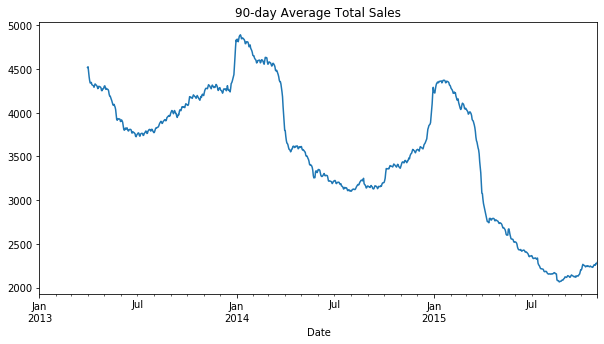

In [6]:
sales_train.groupby('date')['item_cnt_day'].sum()\
.rolling(window=90).mean()\
.plot(y='item_cnt_day', kind='line', colormap='tab20', figsize=(10,5))
plt.title('90-day Average Total Sales')
plt.xlabel('Date')
plt.show()

The trends show large spikes in January of 2014 and 2015. Moreover, there is a downward trend in sales, visible from the 30-day and 90-day average total sales. 

#### Sales by Shop

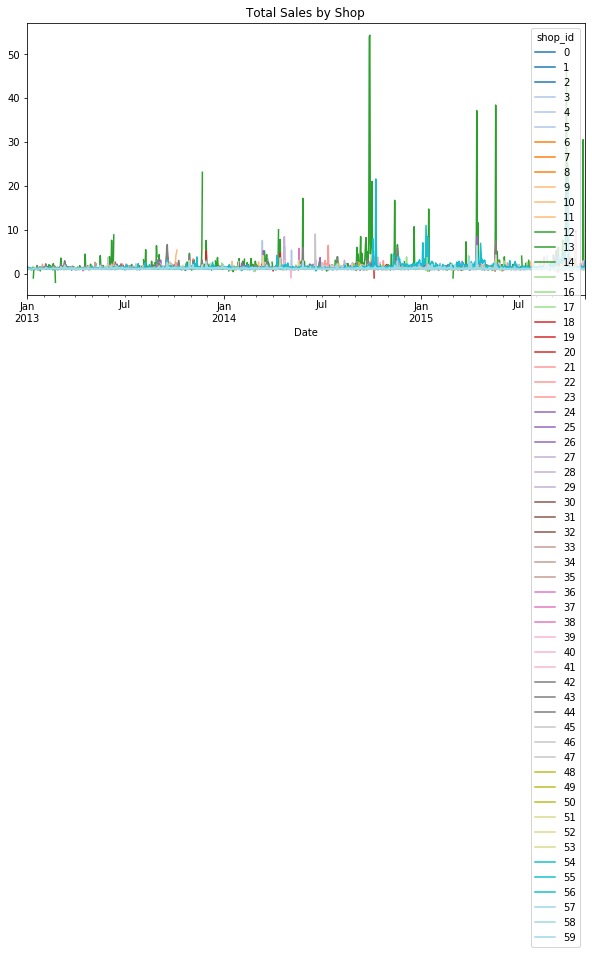

In [7]:
sales_train.groupby(['date', 'shop_id'])['item_cnt_day'].mean()\
.reset_index()\
.set_index(['shop_id', 'date'])\
.unstack('shop_id')\
.plot(y='item_cnt_day', kind='line', colormap='tab20', figsize=(10,5))
plt.title('Total Sales by Shop')
plt.xlabel('Date')
plt.show()

#### Outliers

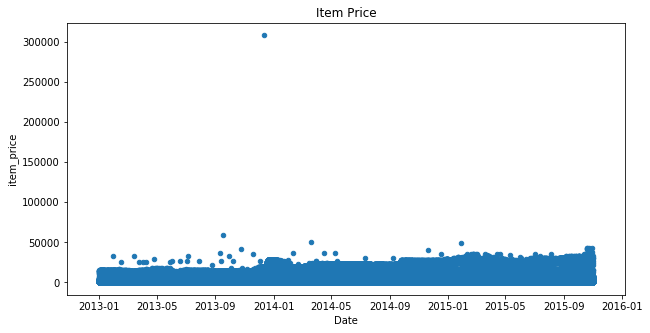

In [50]:
sales_train.plot(x='date', y='item_price', kind='scatter', figsize=(10,5))
plt.title('Item Price')
plt.xlabel('Date')
plt.show()

There is a single item for which price is too high. 

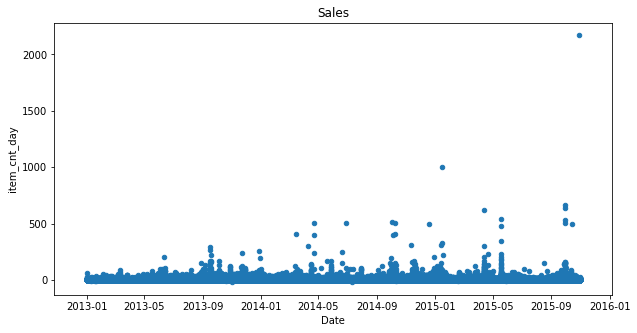

In [51]:
sales_train.plot(x='date', y='item_cnt_day', kind='scatter', figsize=(10,5))
plt.title('Sales')
plt.xlabel('Date')
plt.show()

There is one item for which sales are too high for a particular day.

#### Monthly Sales

In [8]:
sales_monthly = sales_train.groupby(['date_block_num', 'shop_id', 'item_id'])\
.agg({'date':'min', 'item_price':'mean', 'item_cnt_day':'sum'})\
.reset_index()

sales_monthly.head(20)

,date_block_num,shop_id,item_id,date,item_price,item_cnt_day
0,0,0,32,2013-01-03,221.0,6.0
1,0,0,33,2013-01-03,347.0,3.0
2,0,0,35,2013-01-31,247.0,1.0
3,0,0,43,2013-01-31,221.0,1.0
4,0,0,51,2013-01-13,128.5,2.0
5,0,0,61,2013-01-10,195.0,1.0
6,0,0,75,2013-01-17,76.0,1.0
7,0,0,88,2013-01-16,76.0,1.0
8,0,0,95,2013-01-06,193.0,1.0
9,0,0,96,2013-01-10,70.0,1.0


There are 60 unique `shop_id`s and 21807 unique `item_id`s in the dataset. Let's select 5 random products and plot their monthly sales. 

#### Total sales

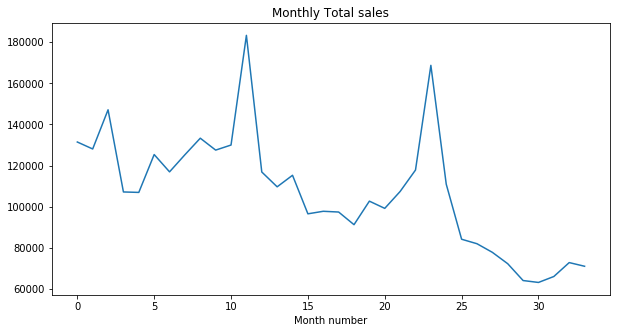

In [9]:
sales_train.groupby('date_block_num')['item_cnt_day'].sum()\
.plot(y='item_cnt_day', kind='line', colormap='tab20', figsize=(10,5))
plt.title('Monthly Total sales')
plt.xlabel('Month number')
plt.show()

### 1.2 Items and Categories
* item_name: name of product.
* item_category_id: unique identifier for product category.
* item_category_name: name of product category. 

In [10]:
items.head(20)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
5,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40
6,***УДАР ПО ВОРОТАМ (UNI) D,6,40
7,***УДАР ПО ВОРОТАМ-2 (UNI) D,7,40
8,***ЧАЙ С МУССОЛИНИ D,8,40
9,***ШУГАРЛЭНДСКИЙ ЭКСПРЕСС (UNI) D,9,40


In [11]:
items['item_category_id'].nunique()

84

There are 84 unique `item_category_id`s, which are the different product categories. 

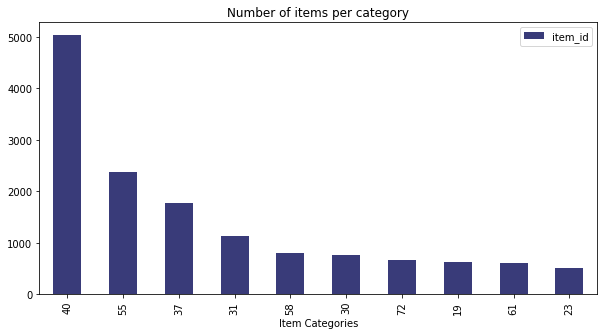

In [34]:
items.groupby('item_category_id')['item_id'].count()\
.sort_values(ascending=False)\
.iloc[0:10]\
.reset_index()\
.set_index('item_category_id')\
.plot(y='item_id', kind='bar', colormap='tab20b', figsize=(10,5))
plt.title('Number of items per category')
plt.xlabel('Item Categories')
plt.show()

In [35]:
item_cat.head(10)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
5,Аксессуары - PSVita,5
6,Аксессуары - XBOX 360,6
7,Аксессуары - XBOX ONE,7
8,Билеты (Цифра),8
9,Доставка товара,9


### 1.3 Shops
* shop_name: name of shop

In [52]:
shops.head(10)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


### 1.4 Translated Data

`item_name`, `item_category_name` and `shop_name` are in Russian. Use data from Kaggle that has translated the names to English.

In [3]:
## Load translated data
shops_trans = pd.read_csv('data/shops-translated.csv')
items_trans = pd.read_csv('data/items-translated.csv')
item_cat_trans = pd.read_csv('data/item_categories-translated.csv')

In [73]:
items_trans.head(10)

,item_id,item_name_translated
0,0,!! IN THE POWER OF HAPPINESS (PLAST) D
1,1,! ABBYY FineReader 12 Professional Edition Ful...
2,2,*** IN THE GLORY OF THE GLORY (UNV) D
3,3,*** BLUE WAVE (Univ) D
4,4,*** BOX (GLASS) D
5,5,*** NEW AMERICAN GRAPHICS (UNI) D
6,6,*** BLOCK ON THE GATES (UNI) D
7,7,*** SHOCK AT DOOR-2 (UNI) D
8,8,*** TEA WITH MUSSOLINI D
9,9,*** SHUGARLEND EXPRESS (UNI) D


In [74]:
item_cat_trans.head(10)

,item_category_id,item_category_name_translated
0,0,PC - Headsets / Headphones
1,1,Accessories - PS2
2,2,Accessories - PS3
3,3,Accessories - PS4
4,4,Accessories - PSP
5,5,Accessories - PSVita
6,6,Accessories - XBOX 360
7,7,Accessories - XBOX ONE
8,8,Tickets (figure)
9,9,Delivery of goods


In [75]:
shops_trans.head(10)

,shop_id,shop_name_translated
0,0,"Yakutsk Ordzhonikidze, 56 francs"
1,1,"Yakutsk TC ""Central"" franc"
2,2,"Adygea Shopping Center ""Mega"""
3,3,"Balashikha TRK ""October-Kinomir"""
4,4,"Volzhsky shopping center ""Volga Mall"""
5,5,"Vologda Shopping and Entertainment Center ""Mar..."
6,6,"Voronezh (Plekhanovskaya, 13)"
7,7,"Voronezh TRC ""Maksimir"""
8,8,"Voronezh TRC City-Park ""Grad"""
9,9,Outbound Trade


### 1.5 Test Data

In [86]:
print('The test data has '+ str(test['shop_id'].nunique()) + ' unique shop_ids and ' + str(test['item_id'].nunique()) + ' unique products.' )

The test data has 42 unique shop_ids and 5100 unique products.


In [3]:
print(test.shape)

(214200, 3)


In [9]:
# Intersection of items in train and test data
len(set(test['item_id']).intersection(set(sales_train['item_id'])))

4737

Out of the 5100 products in the test data, only 4737 are present in the train data. The remaining 363 items are new and have no sales information in the train data. 

In [10]:
len(set(test['shop_id']).intersection(set(sales_train['shop_id'])))

42

## 2. Creating Dataset

* Combine train and test data using `merge` with `how=outer`. This will include all products in train and test datasets.  Products that are not in the train data should have sales=0 in this combined data. 
* Merge `sales_train`, `items` and `item_cat` datasets.
* Also include translated datasets for the Russian names. 
* Downcast dataset.
* Create features for modelling.

In [4]:
## Function to downcast data

def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
                
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
                
        elif t == np.object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    
    return df  

In [57]:
## Function to create dataset

def create_data(istrain=True):
    if istrain:
        df = pd.merge(sales_train, test, how='outer')
        df.drop(['ID'], axis=1, inplace=True)
        df['item_cnt_day'] = (df['item_cnt_day'].fillna(0))
        df = df.merge(items, on='item_id')
        df = df.merge(items_trans, on='item_id')
        df = df.merge(item_cat, on='item_category_id')
        df = df.merge(item_cat_trans, on='item_category_id')
        df = df.merge(shops, on='shop_id')
        df = df.merge(shops_trans, on='shop_id')
    elif not istrain:
        df = pd.merge(sales_train, test, on=['shop_id', 'item_id'])
    
    df = downcast(df)
    
    return(df)

In [58]:
%%time

df = create_data(istrain=True)

df.head()

Wall time: 5.57 s


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_name_translated,item_category_name,item_category_name_translated,shop_name,shop_name_translated
0,2013-01-02,0.0,59,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,SCENE 2012 (BD),Кино - Blu-Ray,Cinema - Blu-Ray,"Ярославль ТЦ ""Альтаир""","Yaroslavl Shopping center ""Altair"""
1,2013-04-26,3.0,59,944,150.0,1.0,2012 (BD),37,2012 (BD),Кино - Blu-Ray,Cinema - Blu-Ray,"Ярославль ТЦ ""Альтаир""","Yaroslavl Shopping center ""Altair"""
2,2013-06-26,5.0,59,944,199.5,1.0,2012 (BD),37,2012 (BD),Кино - Blu-Ray,Cinema - Blu-Ray,"Ярославль ТЦ ""Альтаир""","Yaroslavl Shopping center ""Altair"""
3,2013-07-20,6.0,59,944,199.5,1.0,2012 (BD),37,2012 (BD),Кино - Blu-Ray,Cinema - Blu-Ray,"Ярославль ТЦ ""Альтаир""","Yaroslavl Shopping center ""Altair"""
4,2013-09-14,8.0,59,944,299.0,2.0,2012 (BD),37,2012 (BD),Кино - Blu-Ray,Cinema - Blu-Ray,"Ярославль ТЦ ""Альтаир""","Yaroslavl Shopping center ""Altair"""


In [44]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3038645 entries, 0 to 3038644
Data columns (total 13 columns):
 #   Column                         Dtype         
---  ------                         -----         
 0   date                           datetime64[ns]
 1   date_block_num                 float16       
 2   shop_id                        int8          
 3   item_id                        int16         
 4   item_price                     float32       
 5   item_cnt_day                   float16       
 6   item_name                      category      
 7   item_category_id               int8          
 8   item_name_translated           category      
 9   item_category_name             category      
 10  item_category_name_translated  category      
 11  shop_name                      category      
 12  shop_name_translated           category      
dtypes: category(6), datetime64[ns](1), float16(2), float32(1), int16(1), int8(2)
memory usage: 105.9 MB
None


In [60]:
print('Number of unique shop ids: '+str(df['shop_id'].nunique()))
print('Number of unique item ids: '+str(df['item_id'].nunique()))
print('Number of unique item category ids: '+str(df['item_category_id'].nunique()))

Number of unique shop ids: 60
Number of unique item ids: 22170
Number of unique item category ids: 84


## 3. Baseline Prediction with XGBoost and LightGBM

* Aggregate data to monthly level. 
* Create new categorical variables: city, item type and item subtype. 
* Label encode new categorical variables. Existing categorical variables already label encoded. 
* Run XGBoost and predict using test data. 

### 3.1 Aggregate to monthly

In [34]:
def create_monthly(istrain=True):
    if istrain:
        ## Merge train and test data to get items
        df = pd.merge(sales_train, test, how='outer')
        df.drop(['ID'], axis=1, inplace=True)
        df['item_cnt_day'] = (df['item_cnt_day'].fillna(0))

        ## Aggregate data to monthly
        df['item_cnt_day'] = df['item_cnt_day'].clip(0,20)
        df = df.groupby(['date_block_num', 'shop_id', 'item_id'])\
        .agg({'item_price':'mean', 'item_cnt_day':'sum'})\
        .reset_index()\
        .rename(columns = {'item_cnt_day':'item_cnt_month'})

        df['item_cnt_month'] = df['item_cnt_month'].clip(0,20)

        ## Merge with other supplemental data 
        df = df.merge(items, on='item_id')
        df = df.merge(items_trans, on='item_id')
        df = df.merge(item_cat_trans, on='item_category_id')
        df = df.merge(shops_trans, on='shop_id')
        
        df = downcast(df)
        
    if not istrain:
        ## Create Test dataset with all features
        df = pd.merge(sales_train, test, how='right', on=['shop_id', 'item_id'])
        df['item_cnt_day'] = (df['item_cnt_day'].fillna(0))
        df['date_block_num'] = 33
        
        df = df.merge(items, on=['item_id'])
        df = df.merge(items_trans, on='item_id')
        df = df.merge(item_cat_trans, on='item_category_id')
        df = df.merge(shops_trans, on='shop_id')
        df.drop(['ID'], axis=1, inplace=True)
        df['item_cnt_month'] = 0
        
    
    return(df)


In [18]:
%%time

dfxgb = create_monthly(istrain=True)

dfxgb.head(10)

Wall time: 3.29 s


,date_block_num,shop_id,item_id,item_price,item_cnt_month,item_name,item_category_id,item_name_translated,item_category_name_translated,shop_name_translated
0,0.0,0,32,221.0,6.0,1+1,40,1+1,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs"
1,1.0,0,32,221.0,10.0,1+1,40,1+1,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs"
2,0.0,0,35,247.0,1.0,10 ЛЕТ СПУСТЯ,40,10 YEARS LATER,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs"
3,1.0,0,35,247.0,14.0,10 ЛЕТ СПУСТЯ,40,10 YEARS LATER,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs"
4,0.0,0,43,221.0,1.0,100 МИЛЛИОНОВ ЕВРО,40,100 MILLION EURO,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs"
5,0.0,0,75,76.0,1.0,12 ДРУЗЕЙ ОУШЕНА WB (регион),40,12 FRIENDS OF WASHER OWN (region),Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs"
6,0.0,0,88,76.0,1.0,13 ДРУЗЕЙ ОУШЕНА WB (регион),40,13 FRIENDS OF WASHER OWN (region),Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs"
7,0.0,0,95,193.0,1.0,1812. ЭНЦИКЛОПЕДИЯ ВЕЛИКОЙ ВОЙНЫ,40,1812. ENCYCLOPEDIA OF THE GREAT WAR,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs"
8,0.0,0,96,70.0,1.0,1812. ЭНЦИКЛОПЕДИЯ ВОЙНЫ (регион),40,1812. ENCYCLOPEDIA OF WAR (region),Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs"
9,0.0,0,98,268.0,20.0,1812: УЛАНСКАЯ БАЛЛАДА,40,1812: ULANSKA BALLADA,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs"


### 3.2 New Categorical Variables

In [16]:
def create_cats(data):
    ## Create new categorical variables
    data['city'] = data['shop_name_translated'].str.split(expand=True)[0]
    data['item_type'] = data['item_category_name_translated'].str.split(pat='-', expand=True)[0]
    data['item_subtype'] = data['item_category_name_translated'].str.split(pat='-', expand=True)[1]

    data = downcast(data)
    
    labelcols = ['city', 'item_type', 'item_subtype']
    for col in labelcols:
        data[f'{col}_id'] = data[col].cat.codes.astype('int16')
        data[f'{col}_id'] -= data[f'{col}_id'].min()
            
    meancols = ['shop_id', 'item_id', 'item_category_id', 'city_id', 'item_type_id', 'item_subtype_id']
    for col in meancols:
        data[f'{col}_mean'] = data[[col, 'item_cnt_month']].groupby(col)['item_cnt_month'].mean()
        
    data = downcast(data)
            
    return(data)

In [19]:
%%time

dfxgb = create_cats(dfxgb)

dfxgb.head(10)

Wall time: 4.71 s


,date_block_num,shop_id,item_id,item_price,item_cnt_month,item_name,item_category_id,item_name_translated,item_category_name_translated,shop_name_translated,...,item_subtype,city_id,item_type_id,item_subtype_id,shop_id_mean,item_id_mean,item_category_id_mean,city_id_mean,item_type_id_mean,item_subtype_id_mean
0,0.0,0,32,221.0,6.0,1+1,40,1+1,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",...,DVD,30,3,22,2.330078,1.000000,1.000000,1.862305,2.244141,6.195312
1,1.0,0,32,221.0,10.0,1+1,40,1+1,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",...,DVD,30,3,22,1.903320,1.200195,1.000000,1.633789,4.652344,2.373047
2,0.0,0,35,247.0,1.0,10 ЛЕТ СПУСТЯ,40,10 YEARS LATER,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",...,DVD,30,3,22,1.862305,1.000000,1.846680,1.697266,1.690430,1.446289
3,1.0,0,35,247.0,14.0,10 ЛЕТ СПУСТЯ,40,10 YEARS LATER,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",...,DVD,30,3,22,1.633789,1.000000,3.128906,1.834961,1.694336,3.333984
4,0.0,0,43,221.0,1.0,100 МИЛЛИОНОВ ЕВРО,40,100 MILLION EURO,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",...,DVD,30,3,22,1.739258,1.000000,1.766602,3.082031,3.000000,3.408203
5,0.0,0,75,76.0,1.0,12 ДРУЗЕЙ ОУШЕНА WB (регион),40,12 FRIENDS OF WASHER OWN (region),Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",...,DVD,30,3,22,1.693359,1.000000,1.480469,2.060547,10.242188,1.930664
6,0.0,0,88,76.0,1.0,13 ДРУЗЕЙ ОУШЕНА WB (регион),40,13 FRIENDS OF WASHER OWN (region),Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",...,DVD,30,3,22,1.930664,1.000000,2.402344,1.742188,16.812500,1.232422
7,0.0,0,95,193.0,1.0,1812. ЭНЦИКЛОПЕДИЯ ВЕЛИКОЙ ВОЙНЫ,40,1812. ENCYCLOPEDIA OF THE GREAT WAR,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",...,DVD,30,3,22,1.917969,1.000000,1.916016,2.291016,4.695312,1.085938
8,0.0,0,96,70.0,1.0,1812. ЭНЦИКЛОПЕДИЯ ВОЙНЫ (регион),40,1812. ENCYCLOPEDIA OF WAR (region),Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",...,DVD,30,3,22,1.460938,1.000000,9.109375,1.839844,2.361328,1.192383
9,0.0,0,98,268.0,20.0,1812: УЛАНСКАЯ БАЛЛАДА,40,1812: ULANSKA BALLADA,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",...,DVD,30,3,22,6.773438,1.000000,16.812500,1.906250,2.382812,19.046875


### 3.3 Run XGBoost

In [68]:
dfxgb['item_cnt_month'] = dfxgb.item_cnt_month.fillna(0).clip(0,20)

# Train dataset
xvars = ['date_block_num', 'shop_id', 'item_id', 'item_category_id', 'city_id', 'item_type_id', 'item_subtype_id']
X_train = dfxgb[xvars].set_index('shop_id')
y_train = dfxgb['item_cnt_month']

In [72]:
X_train.head()

,date_block_num,item_id,item_category_id,city_id,item_type_id,item_subtype_id
shop_id,,,,,,
0,0.0,32,40,30,3,22
0,1.0,32,40,30,3,22
0,0.0,35,40,30,3,22
0,1.0,35,40,30,3,22
0,0.0,43,40,30,3,22


In [35]:
%%time

## Create Test dataset with all features
xgb_test = create_monthly(istrain=False)

# xgb_test = create_cats(xgb_test)

# xgb_test['date_block_num'] = 33

xgb_test.head(20)

Wall time: 1.43 s


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_name_translated,item_category_name_translated,shop_name_translated,item_cnt_month
0,2013-01-02,33,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,SCENE 2012 (BD),Cinema - Blu-Ray,"Yaroslavl Shopping center ""Altair""",0
1,2013-06-27,33,59,33,199.00,1.0,1+1 (BD),37,1+1 (BD),Cinema - Blu-Ray,"Yaroslavl Shopping center ""Altair""",0
2,2013-09-07,33,59,33,199.00,1.0,1+1 (BD),37,1+1 (BD),Cinema - Blu-Ray,"Yaroslavl Shopping center ""Altair""",0
3,2013-11-15,33,59,33,199.00,1.0,1+1 (BD),37,1+1 (BD),Cinema - Blu-Ray,"Yaroslavl Shopping center ""Altair""",0
4,2014-01-22,33,59,33,199.00,1.0,1+1 (BD),37,1+1 (BD),Cinema - Blu-Ray,"Yaroslavl Shopping center ""Altair""",0
5,2014-01-29,33,59,33,199.00,1.0,1+1 (BD),37,1+1 (BD),Cinema - Blu-Ray,"Yaroslavl Shopping center ""Altair""",0
6,2014-05-01,33,59,33,199.00,1.0,1+1 (BD),37,1+1 (BD),Cinema - Blu-Ray,"Yaroslavl Shopping center ""Altair""",0
7,2014-12-17,33,59,33,199.00,1.0,1+1 (BD),37,1+1 (BD),Cinema - Blu-Ray,"Yaroslavl Shopping center ""Altair""",0
8,2015-07-21,33,59,33,199.00,1.0,1+1 (BD),37,1+1 (BD),Cinema - Blu-Ray,"Yaroslavl Shopping center ""Altair""",0
9,NaT,33,59,19240,NaN,0.0,СЧАСТЛИВЧИК (BD),37,HAPPY BIRTHDAY (BD),Cinema - Blu-Ray,"Yaroslavl Shopping center ""Altair""",0


In [37]:
xgb_test['item_id'].nunique()

5100

In [76]:
# X_test = xgb_test[xvars].set_index('shop_id')

X_test.head()

# print(X_test.info())

,date_block_num,item_id,item_category_id,city_id,item_type_id,item_subtype_id
shop_id,,,,,,
5,33,5037,19,24,7,33
5,33,5233,19,24,7,33
5,33,4872,19,24,7,33
5,33,5002,19,24,7,33
5,33,5814,19,24,7,33


In [80]:
%%time

## Run XGBoost
fit_xgb = xgb.XGBRegressor(max_depth=10, 
                           min_child_weight=0.5, 
                           subsample=1, 
                           eta=0.3, 
                           num_round=1000, 
                           seed=1, 
                           n_jobs=15, 
                           verbosity=1)

fit_xgb.fit(X_train, y_train, eval_metric='rmse')

pred_xgb = fit_xgb.predict(X_test)

[16:15:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [81]:
xgb_sub = pd.DataFrame(pred_xgb, columns=['item_cnt_month'])
xgb_sub['ID'] = xgb_sub.index
xgb_sub = xgb_sub.set_index('ID')
xgb_sub.to_csv('data/simple_xgb_sub.csv')

In [83]:
print(xgb_sub.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214200 entries, 0 to 214199
Data columns (total 1 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   item_cnt_month  214200 non-null  float32
dtypes: float32(1)
memory usage: 2.5 MB
None


### 3.4 Run LightGBM

## 4. Advanced Prediction with Features

### Feature Engineering

Some new features are created using the `shop_name` and `item_category_name` variables. 
* `city`: the `shop_name` starts with the name of the city.
* `item_type`: the first part of `item_category_name` tells us the product type. 
* `item_subtype`: the second part of `item_category_name` tells us the product subtype. 

For example, the product "Cinema - Blu-Ray" is of type "Cinema" and subtype "BluRay".

Next we have to encode categorical varibles. Two types of encoding are included in the function below. A simple label encoding where each category of a variable are assigned a number. The problem with this type of encoding is it creates a hierarchy within the different categories, which is misleading during modelling. In this dataset, `shop_id`, `item_id` and `item_category_id` are already numeric and don't need to be label encoded. 

The second type of encoding is mean/target encoding, where each category of the variable is replaced by mean of the target variable (in this case the mean daily sales). This does not create a hierarchy among the categories. Other encoding methods will be inlcuded later. 

Some trend features for each shop-item pair.
* 7, 28-day lag daily sales.
* 7 and 28-day rolling means for lag daily sales. 

Note that the lags and rolling means are grouped by `shop_id` and `item_id`, since the final predictions also have to be made for each shop-item pair. 
* Calendar variables: day of the week, day of the month, week of the year, month, quarter and year.

In [ ]:
## Function to create features
def create_features(data, encode='label'):
    # Create some features from shop names and item category names
    data['city'] = data['shop_name_translated'].str.split(expand=True)[0]
    data['item_type'] = data['item_category_name_translated'].str.split(pat='-', expand=True)[0]
    data['item_subtype'] = data['item_category_name_translated'].str.split(pat='-', expand=True)[1]
    
    df = downcast(df)
    
    # Encoding categorical features
    if encode=='label':
        labelcols = ['city', 'item_type', 'item_subtype']
        for cols in labelcols:
            data[f'{col}_id'] = data[col].cat.codes.astype('int16')
            data[f'{col}_id'] -= data[f'{col}_id'].min()
            
    elif encode=='mean':
        meancols = ['shop_id', 'item_id', 'item_category_id', 'city', 'item_type', 'item_subtype']
        for col in meancols:
            data[f'{col}_enc'] = data[[col, 'sales']].groupby(col)['sales'].mean()
            
    # Create lags of daily sales
    lags=[7, 28]
    for lag in lags:
        data[f'lag_{lag}'] = data[['date', 'shop_id', 'item_id', 'item_cnt_day']].sort_values('date').groupby(['shop_id', 'item_id',])['item_cnt_day'].shift(lag)
        
    
    # Create rolling means of lag daily sales
    windows=[7, 28, 90]
    for win in windows:
        data[f'rmean_{win}'] = data[['shop_id', 'item_id', 'item_cnt_day']].groupby(['shop_id', 'item_id',])['item_cnt_day'].sum().rolling(window=win).mean()
    
    
    # Calendar trend variables
    date_feats = {'wday':'weekday', 
                  'week':'weekofyear', 
                  'month':'month', 
                  'quarter':'quarter',
                  'year':'year',
                  'days':'day'}
    
    
        

    return data   
    

In [81]:
print(df['item_name_translated'])

0                                            SCENE 2012 (BD)
1                                                  2012 (BD)
2                                                  2012 (BD)
3                                                  2012 (BD)
4                                                  2012 (BD)
                                 ...                        
2935844    Windows payment card: 250 rubles [Digital vers...
2935845    Windows payment card: 1000 rubles [Digital ver...
2935846    Windows payment card: 2500 rubles [Digital ver...
2935847    Windows payment card: 2500 rubles [Digital ver...
2935848    Windows payment card: 2000 rubles [Digital ver...
Name: item_name_translated, Length: 2935849, dtype: category
Categories (21788, object): [! ABBYY FineReader 12 Professional Edition Ful..., !! IN THE POWER OF HAPPINESS (PLAST) D, * Beyond Death's Edge D, * LINE OF COMMENTS D, ..., ЭПИК (BD), ЭРГАГОН (ХХСС), ЭкПАТ (DVD + BD), ЭкспАТ (BD)]
